In [1]:
"""
Perform a Text Classification on consumer complaint dataset
(https://catalog.data.gov/dataset/consumer-complaint-database) into following categories.

0 Credit reporting, repair, or other
1 Debt collection
2 Consumer Loan
3 Mortgage

Steps to be followed -
1. Explanatory Data Analysis and Feature Engineering
2. Text Pre-Processing
3. Selection of Multi Classification model
4. Comparison of model performance
5. Model Evaluation
6. Prediction

"""

'\nPerform a Text Classification on consumer complaint dataset\n(https://catalog.data.gov/dataset/consumer-complaint-database) into following categories.\n\n0 Credit reporting, repair, or other\n1 Debt collection\n2 Consumer Loan\n3 Mortgage\n\nSteps to be followed -\n1. Explanatory Data Analysis and Feature Engineering\n2. Text Pre-Processing\n3. Selection of Multi Classification model\n4. Comparison of model performance\n5. Model Evaluation\n6. Prediction\n\n'

# IMPORTING LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string

from scipy.stats import randint

from io import StringIO

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# DATA EXPLORATION

In [3]:
df = pd.read_csv('complaints.csv')
df.head().T

C:\Users\sjaru\AppData\Local\Temp\ipykernel_1440\719507999.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('complaints.csv')


,0,1,2,3,4
Date received,2023-08-25,2023-08-25,2023-08-23,2023-08-23,2023-08-23
Product,Credit reporting or other personal consumer re...,Credit reporting or other personal consumer re...,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o...",Credit card or prepaid card
Sub-product,Credit reporting,Credit reporting,Credit reporting,Credit reporting,General-purpose credit card or charge card
Issue,Improper use of your report,Incorrect information on your report,Improper use of your report,Improper use of your report,"Other features, terms, or problems"
Sub-issue,Reporting company used your report improperly,Information belongs to someone else,Reporting company used your report improperly,Reporting company used your report improperly,Other problem
Consumer complaint narrative,NaN,NaN,NaN,NaN,NaN
Company public response,NaN,NaN,NaN,NaN,NaN
Company,"SANTANDER HOLDINGS USA, INC.",WELLS FARGO & COMPANY,Experian Information Solutions Inc.,Experian Information Solutions Inc.,"CITIBANK, N.A."
State,FL,CA,WA,OR,WI
ZIP code,33972,92394,98507,97209,53058


In [4]:
df.count()

Date received                   4042985
Product                         4042985
Sub-product                     3807694
Issue                           4042985
Sub-issue                       3327227
Consumer complaint narrative    1464248
Company public response         1868451
Company                         4042985
State                           3999820
ZIP code                        4012777
Tags                             423775
Consumer consent provided?      3142965
Submitted via                   4042985
Date sent to company            4042985
Company response to consumer    4042980
Timely response?                4042985
Consumer disputed?               768358
Complaint ID                    4042985
dtype: int64

In [5]:
df.shape

(4042985, 18)

In [6]:
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint'] 

df1.shape

(1464248, 2)

In [7]:
# Percentage of complaints with text
total = df1['Consumer_complaint'].notnull().sum()
round((total/len(df)*100),1)

36.2

In [8]:
pd.DataFrame(df.Product.unique()).values

array([['Credit reporting or other personal consumer reports'],
       ['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Credit card or prepaid card'],
       ['Debt collection'],
       ['Mortgage'],
       ['Checking or savings account'],
       ['Vehicle loan or lease'],
       ['Credit card'],
       ['Payday loan, title loan, or personal loan'],
       ['Student loan'],
       ['Money transfer, virtual currency, or money service'],
       ['Payday loan, title loan, personal loan, or advance loan'],
       ['Debt or credit management'],
       ['Prepaid card'],
       ['Credit reporting'],
       ['Consumer Loan'],
       ['Bank account or service'],
       ['Payday loan'],
       ['Money transfers'],
       ['Other financial service'],
       ['Virtual currency']], dtype=object)

# DATA PREPROCESSING

In [9]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df1.sample(10000, random_state=1).copy()

In [10]:
# Renaming categories
df2.replace({'Product': 
            {'Credit reporting or other personal consumer reports': 'Credit reporting, repair, or other',
                'Credit reporting, credit repair services, or other personal consumer reports': 'Credit reporting, repair, or other',
                'Credit card or prepaid card': 'Credit card or prepaid card',
                'Debt collection': 'Debt collection',
                'Mortgage': 'Mortgage',
                'Checking or savings account': 'Consumer Loan',  
                'Vehicle loan or lease': 'Consumer Loan',      
                'Credit card': 'Credit card or prepaid card',
                'Payday loan, title loan, or personal loan': 'Consumer Loan',
                'Student loan': 'Consumer Loan',
                'Money transfer, virtual currency, or money service': 'Consumer Loan',
                'Payday loan, title loan, personal loan, or advance loan': 'Consumer Loan',
                'Debt or credit management': 'Credit reporting, repair, or other',
                'Prepaid card': 'Credit card or prepaid card',
                'Credit reporting': 'Credit reporting, repair, or other',
                'Consumer Loan': 'Consumer Loan',
                'Bank account or service': 'Consumer Loan',   
                'Payday loan': 'Consumer Loan',
                'Money transfers': 'Consumer Loan',
                'Other financial service': 'Credit reporting, repair, or other',
                'Virtual currency': 'Credit reporting, repair, or other'}}, 
            inplace= True)

In [11]:
pd.DataFrame(df2.Product.unique())

,0
0,"Credit reporting, repair, or other"
1,Consumer Loan
2,Mortgage
3,Credit card or prepaid card
4,Debt collection


In [12]:
# The number of classes were reduced from 22 to 5.
# Now we need to represent each class as a number, so as our predictive model can better understand the different categories.

# VISUALISING PROCESSED DATA

In [13]:
# Create a new column 'category_id' with encoded categories 
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()

# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head()

,Product,Consumer_complaint,category_id
2054782,"Credit reporting, repair, or other",accordance with the Fair Credit Reporting act ...,0
1540532,Consumer Loan,I had an account since XXXX 2012 with capital ...,1
2721658,Mortgage,"My name is XXXX XXXX XXXX, I am an XXXX who r...",2
1596292,Credit card or prepaid card,Bank of America is denying credit based on fed...,3
580828,Debt collection,I not only dispute the debt validity because t...,4


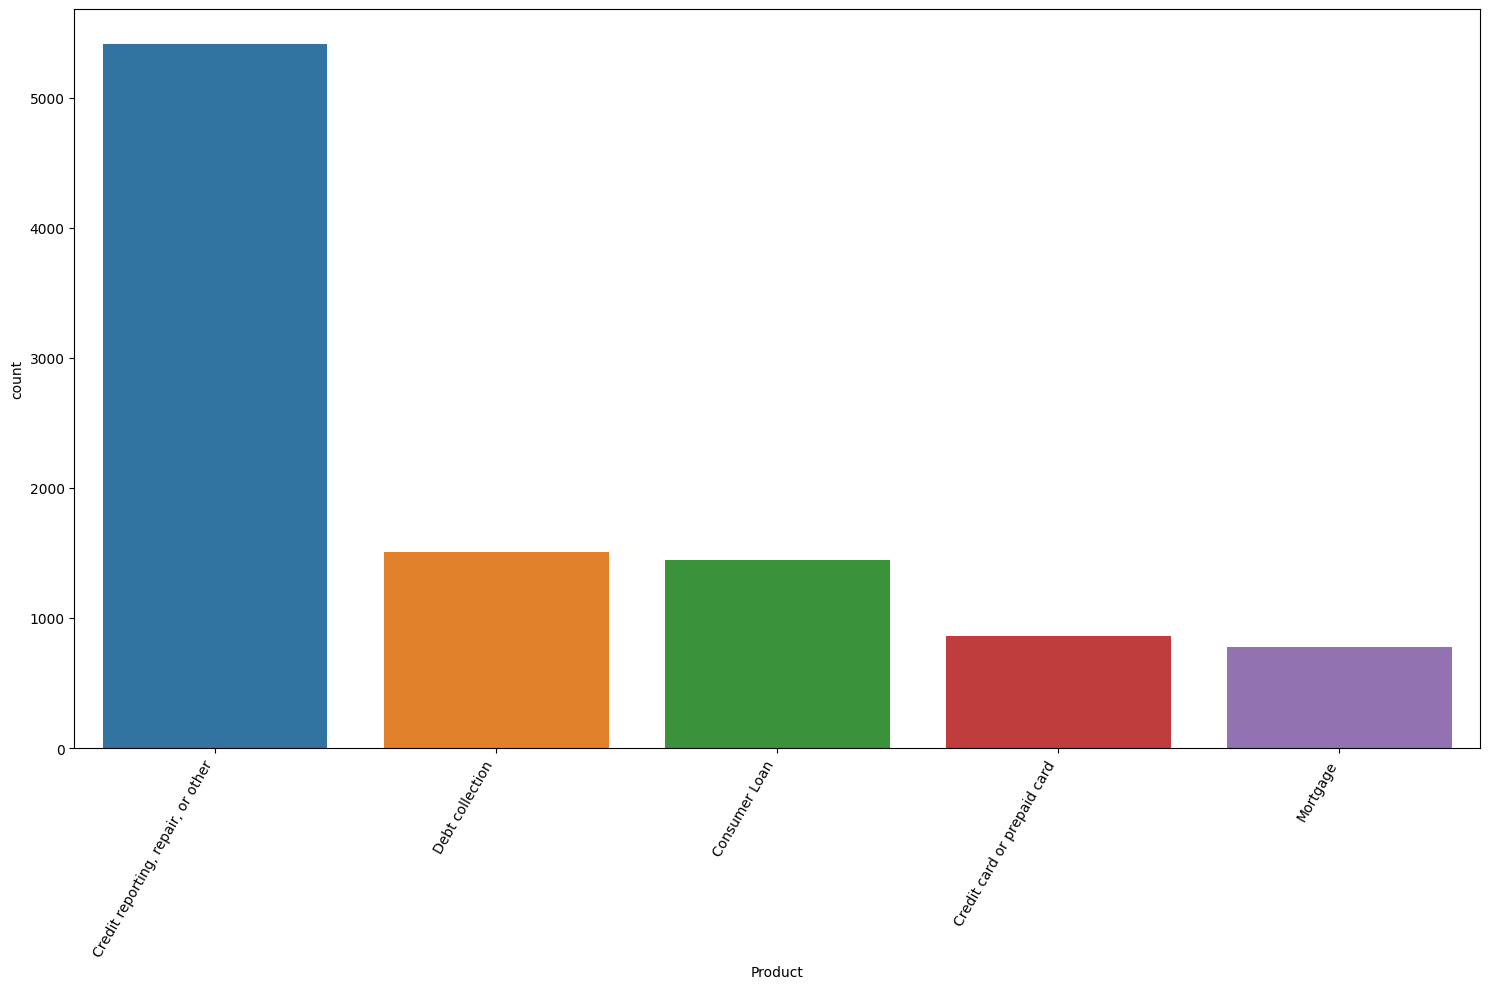

Product
Credit reporting, repair, or other    5410
Debt collection                       1509
Consumer Loan                         1447
Credit card or prepaid card            860
Mortgage                               774
Name: count, dtype: int64


In [14]:
value_counts = df2['Product'].value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(x='Product', data=df2, order=value_counts.index, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')

plt.tight_layout()
plt.show()

print(value_counts)

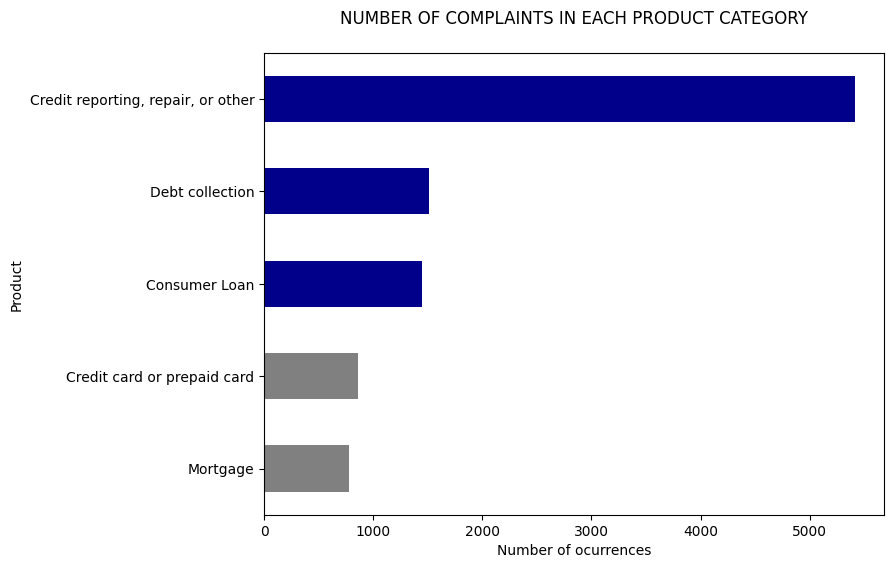

In [15]:
fig = plt.figure(figsize=(8,6))

colors = ['grey','grey','darkblue','darkblue','darkblue']

df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')

plt.xlabel('Number of ocurrences', fontsize = 10);

# TEXT DATA PREPROCESSING AND FEATURE ENGINEERING USING TF-IDF VECTORIZATION

In [16]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 26190 features (TF-IDF score of unigrams and bigrams)


In [17]:
# Number of top correlated terms to display
N = 3

# Loop through categories
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    
    print("\n==> %s:" % (Product))
    print("  * Most Correlated Unigrams are: %s" % (', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" % (', '.join(bigrams[-N:])))


==> Consumer Loan:
  * Most Correlated Unigrams are: money, funds, bank
  * Most Correlated Bigrams are: wells fargo, overdraft fees, checking account

==> Credit card or prepaid card:
  * Most Correlated Unigrams are: merchant, citi, card
  * Most Correlated Bigrams are: card company, american express, credit card

==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: 1681, section, reporting
  * Most Correlated Bigrams are: credit report, 15 1681, 1681 section

==> Debt collection:
  * Most Correlated Unigrams are: collect, collection, debt
  * Most Correlated Bigrams are: collect debt, portfolio recovery, collection agency

==> Mortgage:
  * Most Correlated Unigrams are: modification, escrow, mortgage
  * Most Correlated Bigrams are: escrow account, mortgage company, loan modification


In [18]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 5 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

# MODEL BUILDING AND EVALUATION

In [36]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, max_iter=1000)
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\sjaru\miniconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\sjaru\miniconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\sjaru\miniconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\sjaru\miniconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\sjaru\miniconda3\Lib\site-packages\sklearn\svm\

In [37]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']

acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.8492,0.007555
LogisticRegression,0.8419,0.008685
MultinomialNB,0.7357,0.002752
RandomForestClassifier,0.5415,0.000354


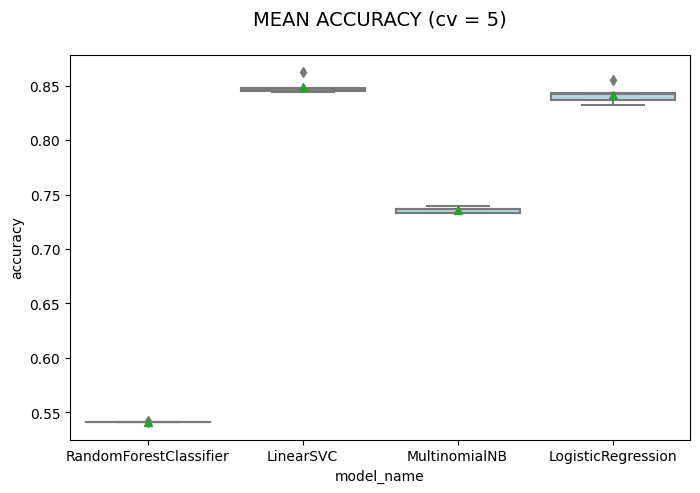

In [38]:
plt.figure(figsize=(8,5))

sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)

plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    features, labels, df2.index, test_size=0.25,random_state=1, stratify=labels
)

model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


C:\Users\sjaru\miniconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [23]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred,target_names= df2['Product'].unique()))

				CLASSIFICATIION METRICS

                                    precision    recall  f1-score   support

Credit reporting, repair, or other       0.89      0.93      0.91      1352
                     Consumer Loan       0.78      0.81      0.80       362
                          Mortgage       0.87      0.82      0.85       194
       Credit card or prepaid card       0.80      0.73      0.76       215
                   Debt collection       0.79      0.69      0.74       377

                          accuracy                           0.85      2500
                         macro avg       0.83      0.80      0.81      2500
                      weighted avg       0.85      0.85      0.85      2500



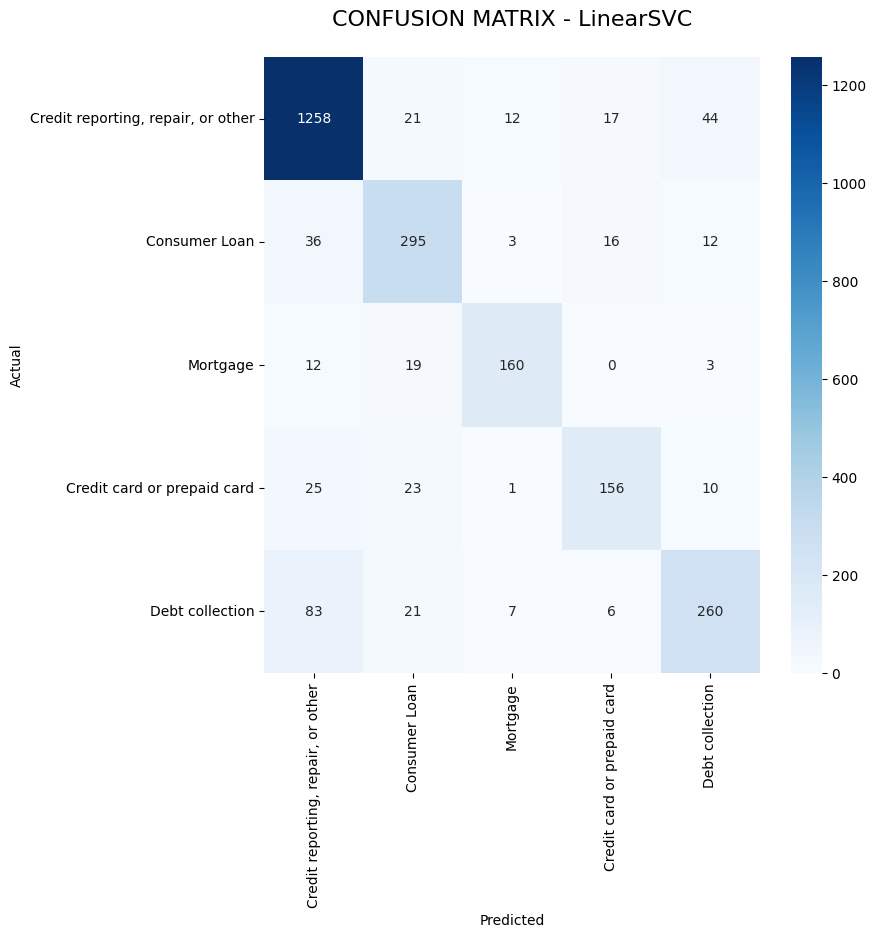

In [24]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [25]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
    
      display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 
                                                                'Consumer_complaint']])
      print('')

'Consumer Loan' predicted as 'Credit reporting, repair, or other' : 36 examples.


,Product,Consumer_complaint
2924625,Consumer Loan,"In XX/XX/XXXX, I contacted the 3 credit bureau..."
2333569,Consumer Loan,Made auto payment that cleared through my bank...
3851916,Consumer Loan,You guys responded the account is cclosed but ...
850570,Consumer Loan,I am reporting The XXXXXXXX Family on behalf o...
856494,Consumer Loan,I never received this loan the company showing...
1922793,Consumer Loan,I was browsing the various options for product...
1857214,Consumer Loan,"Two payments were made, the first on XX/XX/XXX..."
535820,Consumer Loan,To Whom It May Concern : RE : ACCOUNT- XXXX Go...
1319584,Consumer Loan,On Friday XX/XX/2018 I spoke with Collections ...
2449466,Consumer Loan,Ford Motor Credit is reporting a repossession ...



'Credit card or prepaid card' predicted as 'Credit reporting, repair, or other' : 25 examples.


,Product,Consumer_complaint
1054470,Credit card or prepaid card,So many issues with this account I have been i...
2218159,Credit card or prepaid card,"My previous claim XXXX, against creditor USAA ..."
893272,Credit card or prepaid card,For months I have not been able to access this...
1289219,Credit card or prepaid card,My separated husband has opened credit cards i...
2659509,Credit card or prepaid card,See the attached documents. I want the bureau ...
392833,Credit card or prepaid card,JP Morgan Chase has decided to decrease my cre...
1388833,Credit card or prepaid card,I have been an exclusive Apple device owner & ...
3752579,Credit card or prepaid card,I went to the Conns store to purchase applianc...
3596219,Credit card or prepaid card,I received a letter ( XX/XX/19 ) from WFFinanc...
2787125,Credit card or prepaid card,There a Home Depot card in my name and made me...



'Debt collection' predicted as 'Credit reporting, repair, or other' : 83 examples.


,Product,Consumer_complaint
1868286,Debt collection,I sent XXXX XXXX XXXX a letter asking to verif...
2123455,Debt collection,To Whom It May Concern : I have recently been ...
1262366,Debt collection,I am a victim of identity theft. I recently le...
2678712,Debt collection,"Dear Support Representative, I just discovered..."
3882843,Debt collection,NEVER HAD A LEGAL OBLIGATION OR APPLY FOR A LI...
...,...,...
1775276,Debt collection,Enhanced Recovery placed an account from XXXX ...
2874855,Debt collection,"My name is XXXX XXXX , SSN XXXX DOB XX..."
1808825,Debt collection,Dear Consumer Financial Credit Protection Bure...
1499117,Debt collection,The credit bureaus refused to provide you thei...



'Credit reporting, repair, or other' predicted as 'Consumer Loan' : 21 examples.


,Product,Consumer_complaint
1586860,"Credit reporting, repair, or other",I went to cash my payroll check at XXXX and it...
3776992,"Credit reporting, repair, or other",I opened an account with West Creek Financial ...
2617093,"Credit reporting, repair, or other",I received a call from a student loan company ...
282382,"Credit reporting, repair, or other",I have contacted Navient about the account rep...
1489921,"Credit reporting, repair, or other",I applied for student loan forgiveness for 4 s...
3248696,"Credit reporting, repair, or other",Wrong addresses. precious wong name listings. ...
1272135,"Credit reporting, repair, or other",I did a loan consolidation in XX/XX/XXXX with ...
2069144,"Credit reporting, repair, or other",Westlake Financial Services has placed false &...
160985,"Credit reporting, repair, or other","Sometime around the end of XXXX, beginning of ..."
250793,"Credit reporting, repair, or other","On XX/XX/2021, never applied for any car loans..."



'Credit card or prepaid card' predicted as 'Consumer Loan' : 23 examples.


,Product,Consumer_complaint
530410,Credit card or prepaid card,- Approved for BBVA ClearPoints card on XX/XX/...
1478167,Credit card or prepaid card,I went around XXXX XXXX time on XX/XX/2022 to ...
1020831,Credit card or prepaid card,"On XX/XX/XXXX wife passed, on or about XX/XX/X..."
3471150,Credit card or prepaid card,I went to XXXX and did a rental with budget ca...
4017371,Credit card or prepaid card,Executive Summary. This is a breach of contrac...
3604548,Credit card or prepaid card,I paid for a watch with 2 day shipping so I co...
1644913,Credit card or prepaid card,I I have a checking account US Bank and my acc...
1549715,Credit card or prepaid card,I have an open credit account with Synchrony B...
3933004,Credit card or prepaid card,My account was closed after informing the bank...
3022306,Credit card or prepaid card,In XXXX of XXXX I was issued a Bank of America...



'Debt collection' predicted as 'Consumer Loan' : 21 examples.


,Product,Consumer_complaint
1478128,Debt collection,i was renting spot from a man to open a XXXX i...
3230112,Debt collection,MY IDENTITY WAS STOLEN FROM ME. PNC CARD WAS N...
594811,Debt collection,XX/XX/XXXX. email to company XXXX XXXX XXXX XX...
3501817,Debt collection,XX/XX/2020 WE my wife and I bought a set of so...
674212,Debt collection,I received a notice on XX/XX/XXXX stating that...
2608566,Debt collection,"XXXX XX/XX/2020, both consumers entered into a..."
3402892,Debt collection,XXXX XXXX XXXX XXXX XXXX \nSearch XXXX Multi-...
1417966,Debt collection,VRS debited checking account without approval ...
3460196,Debt collection,"Back in XXXX, I reached out to Klarna about an..."
2463837,Debt collection,Back in XXXX XXXX XXXX I had repeatedly contac...



'Credit reporting, repair, or other' predicted as 'Debt collection' : 44 examples.


,Product,Consumer_complaint
748589,"Credit reporting, repair, or other",XXXX XXXX determined a loan that they had for ...
2985487,"Credit reporting, repair, or other",I sent of letter of dispute asking about proof...
549046,"Credit reporting, repair, or other",I C Systems has negatively reported {$2600.00}...
1944842,"Credit reporting, repair, or other",I have disputed XXXX XXXX because this was acc...
3631206,"Credit reporting, repair, or other",Debt owed to the collection agency has been pa...
2839015,"Credit reporting, repair, or other",The company Portfolio Recovery sent a letter t...
3467287,"Credit reporting, repair, or other",On my XXXX credit report dated XX/XX/XXXX I ha...
3599423,"Credit reporting, repair, or other","On XXXX XXXX, 2017, Monterey Collections Sv. w..."
863801,"Credit reporting, repair, or other",I received a release of IRS and Minnesota Reve...
3185153,"Credit reporting, repair, or other",Barclays Delaware creditor have some fraudulen...


In [26]:
model.fit(features, labels)

N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))

C:\Users\sjaru\miniconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



==> 'Consumer Loan':
  * Top unigrams: navient, money, loan, chime
  * Top bigrams: debit card, line credit, account charged, savings account

==> 'Credit card or prepaid card':
  * Top unigrams: card, capital, citi, synchrony
  * Top bigrams: balance transfer, paypal credit, best buy, american express

==> 'Credit reporting, repair, or other':
  * Top unigrams: equifax, experian, transunion, reporting
  * Top bigrams: xxxx xxxx, told company, delete account, payments account

==> 'Debt collection':
  * Top unigrams: debt, collection, calls, apartment
  * Top bigrams: loan took, portfolio recovery, xxxx say, investigation remove

==> 'Mortgage':
  * Top unigrams: mortgage, escrow, modification, home
  * Top bigrams: title company, credit like, escrow account, selene finance


# MODEL SELECTION AND IMPLEMENTATION

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

C:\Users\sjaru\miniconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


### PREDICTIONS

In [28]:
new_complaint_credit = """I noticed an error on my credit report. There is an account that does not belong to me, and it's affecting my credit score."""
print(model.predict(fitted_vectorizer.transform([new_complaint_credit])))

['Credit reporting, repair, or other']


In [29]:
complaint_credit_2 = """I found inaccuracies in my credit report, and I have already submitted disputes to correct them. However, these errors are still affecting my credit score."""
print(model.predict(fitted_vectorizer.transform([complaint_credit_2])))

['Credit reporting, repair, or other']


In [30]:
new_complaint_debt = """I keep receiving calls from a debt collection agency for a debt that I have already paid off. This is harassment, and I want it to stop."""
print(model.predict(fitted_vectorizer.transform([new_complaint_debt])))

['Debt collection']


In [31]:
complaint_debt_2 = """I've been receiving relentless calls from a debt collector, even after I've explained that I cannot make payments at the moment due to financial hardship."""
print(model.predict(fitted_vectorizer.transform([complaint_debt_2])))

['Debt collection']


In [32]:
new_complaint_loan = """I applied for a consumer loan, but the interest rate they offered is much higher than what was initially advertised. This is misleading and unfair."""
print(model.predict(fitted_vectorizer.transform([new_complaint_loan])))

['Consumer Loan']


In [33]:
new_complaint_loan_2 = """I recently applied for a consumer loan to purchase a new car. The loan was approved, 
                            but the interest rate they offered is much higher than what I was initially quoted. 
                            This is causing a significant financial burden, and I believe this is unfair and deceptive lending."""
print(model.predict(fitted_vectorizer.transform([new_complaint_loan_2])))

['Consumer Loan']


In [34]:
new_complaint_mortgage = """I've been trying to get a mortgage for my new home, but the mortgage company has been delaying the process and requesting unnecessary paperwork."""
print(model.predict(fitted_vectorizer.transform([new_complaint_mortgage])))

['Mortgage']


In [35]:
complaint_mortgage_2 = """My mortgage lender has been repeatedly making errors in processing my payments, which is affecting my credit score and causing financial stress."""
print(model.predict(fitted_vectorizer.transform([complaint_mortgage_2])))

['Credit reporting, repair, or other']
